In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Do a basic overview of what the tables are using inspector 
#Create inspector engine
inspector = inspect(engine)
#explore measurement
columns = inspector.get_columns("measurement")
for column in columns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#explore station
columns = inspector.get_columns("station")
for column in columns: 
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
#convert all dates to datetime
for row in session.query(Measurement).order_by(Measurement.date.desc()).limit(1):
    latest_date = dt.datetime.strptime(row.date,'%Y-%m-%d')

#Find out timeframe
one_year_ago = latest_date - dt.timedelta(365)
print(f'Last Date: {latest_date}')
print(f'One year ago: {one_year_ago}')

Last Date: 2017-08-23 00:00:00
One year ago: 2016-08-23 00:00:00


In [13]:
# Design a query to retrieve the last 12 months of precipitation data
# Find the average for each day
daily_avg_pcrp = session.query(Measurement.date, func.avg(Measurement.prcp)).\
                    filter(Measurement.date >= one_year_ago).\
                    group_by(Measurement.date)
daily_avg_pcrp

In [14]:
# Perform a query to retrieve the data and precipitation scores
percipiration_df = pd.read_sql_query(daily_avg_pcrp.statement, session.get_bind())
percipiration_df.info()
percipiration_df

# Drop unavailable columns
percipiration_df = percipiration_df.dropna()
percipiration_df

# Save the query results as a Pandas DataFrame and set the index to the date column
percipiration_df = percipiration_df.set_index("date", drop=False)
percipiration_df = percipiration_df.rename(columns=
                                  {"date":"Date",
                                  "avg_1":"Precipitation"})
percipiration_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
date     365 non-null object
avg_1    365 non-null float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


,Date,Precipitation
date,,
2016-08-24,2016-08-24,1.555000
2016-08-25,2016-08-25,0.077143
2016-08-26,2016-08-26,0.016667
2016-08-27,2016-08-27,0.064000
2016-08-28,2016-08-28,0.516667
...,...,...
2017-08-19,2017-08-19,0.030000
2017-08-20,2017-08-20,0.005000
2017-08-21,2017-08-21,0.193333


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text xticklabel objects>)

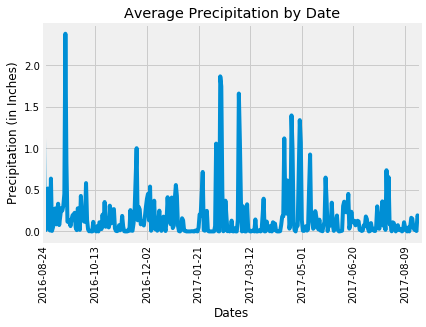

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_chart = percipiration_df.plot(x='Date',y='Precipitation', legend=False)

plt.xlabel("Dates")
plt.ylabel("Precipitation (in Inches)")
plt.title("Average Precipitation by Date")
plt.xticks(rotation=90)

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
percipiration_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [17]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
station_data = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()
# station_data
print(f'The most active station is {station_data[0][0]}')

The most active station is USC00519281


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == station_data[0][0]).all() 
avg_tempr = round(avg_temp[0][0],2)
min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == station_data[0][0]).all()
max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == station_data[0][0]).all()


print(f'Station {station_data[0][0]} recorded an average temperature of {avg_tempr} degrees with lows of {min_temp[0][0]} degrees and highs of {max_temp[0][0]} degrees')

Station USC00519281 recorded an average temperature of 71.66 degrees with lows of 54.0 degrees and highs of 85.0 degrees


In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temp_observation_station = session.query(Measurement.tobs).\
                                    filter(Measurement.date > one_year_ago).\
                                    filter(Measurement.station == station_data[0][0]).all()

In [21]:
#Pandas Dataframe
most_temp_station_df = pd.DataFrame(most_temp_observation_station)

Text(0, 0.5, 'Amount')

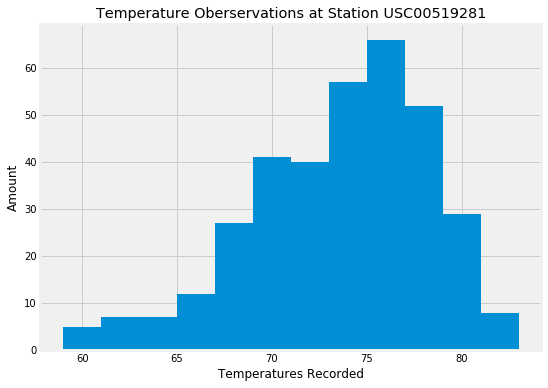

In [22]:
#Histogram
most_temp_station_df.plot.hist('tobs', bins=12, figsize=(8,6), title=(f'Temperature Oberservations at Station {station_data[0][0]}'),legend=False)
plt.xlabel('Temperatures Recorded')
plt.ylabel('Amount')

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-01-28', '2012-03-05'))

[(56.0, 69.36486486486487, 78.0)]


In [24]:
print(f'Last Date: {latest_date}')
print(f'One year ago: {one_year_ago}')

Last Date: 2017-08-23 00:00:00
One year ago: 2016-08-23 00:00:00


In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
one_year = calc_temps('2016-08-23', '2017-08-23')
one_year

[(58.0, 74.59058295964125, 87.0)]

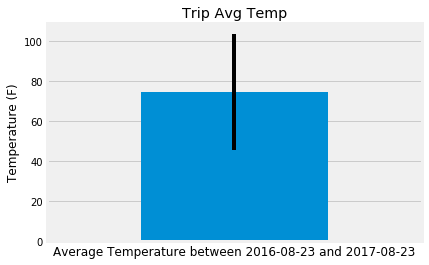

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
one_year_df = pd.DataFrame(one_year, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = one_year_df['Avg Temp']
min_max_temp = one_year_df.iloc[0]['Max Temp'] - one_year_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp)
plt.title("Trip Avg Temp")
plt.xlabel("Average Temperature between 2016-08-23 and 2017-08-23")
plt.ylabel("Temperature (F)")
plt.xticks([])
plt.show()

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

rainfall = session.query(Measurement.station, func.sum(Measurement.prcp)).\
            filter(Measurement.date >= one_year_ago).filter(Measurement.date <= latest_date).\
            group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall

[('USC00516128', 147.11000000000004),
 ('USC00519281', 68.24000000000002),
 ('USC00513117', 48.36000000000003),
 ('USC00519523', 37.99),
 ('USC00514830', 33.19),
 ('USC00519397', 16.089999999999986),
 ('USC00517948', 4.59)]

In [28]:
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station,Station.name,func.sum(Measurement.prcp),Station.latitude,Station.longitude,Station.elevation]
results = session.query(*sel).filter(Measurement.station==Station.station).\
                       filter(Measurement.date>=one_year_ago).filter(Measurement.date<=latest_date).\
                       group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
#Put them all in one row
for x in results: 
    x[6:]
    print(x)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 147.11000000000004, 21.3331, -157.8025, 152.4)
('USC00519281', 'WAIHEE 837.5, HI US', 68.24000000000002, 21.45167, -157.84888999999998, 32.9)
('USC00513117', 'KANEOHE 838.1, HI US', 48.36000000000003, 21.4234, -157.8015, 14.6)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 37.99, 21.33556, -157.71139, 19.5)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 33.19, 21.5213, -157.8374, 7.0)
('USC00519397', 'WAIKIKI 717.2, HI US', 16.089999999999986, 21.2716, -157.8168, 3.0)
('USC00517948', 'PEARL CITY, HI US', 4.59, 21.3934, -157.9751, 11.9)


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-16'
end_date ='2017-08-23'
# Use the start and end date to create a range of dates
dates = session.query(Measurement.date).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.date).all()
dates
#put in a list
result = [r[0] for r in dates]
result

# remove the years
def remove_cruft(s):
    return s[5:]
trip_dates = [remove_cruft(s) for s in result]
first_trip_day = trip_dates[0]
last_trip_day = trip_dates[-1]

# # query  the list of month/date to get the range across the dataset 
daily_normals = [session.query(func.min(Measurement.tobs),
                       func.avg(Measurement.tobs),
                       func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= first_trip_day).filter(func.strftime("%m-%d", Measurement.date) <= last_trip_day).group_by(func.strftime("%m-%d", Measurement.date)).all()]
daily_normals
daily_normals = daily_normals[0]
daily_normals

[(69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# Create a dataframe from the previous query 
daily_normals_df= pd.DataFrame(daily_normals,columns=['tmin', 'tavg', 'tmax'])
daily_normals_df
# Add trip_dates to Pandas DataFrame
daily_normals_df['dates']= trip_dates
daily_normals_df
# # # Change datatype from element to datetime object on Pandas, makes x axis title to add 
# daily_normals_df['date'] = pd.to_datetime(daily_normals_df['date'], format='%Y-%m-%d')

# # Set index to date
daily_normals_df.set_index('dates',inplace=True)
daily_normals_df
daily_normals_df = daily_normals_df.rename(columns=
                                  {"tmin":"Minimum Temperature",
                                  "tavg":"Average Temperature", 
                                  "tmax": "Maximum Temperature"})
daily_normals_df

,Minimum Temperature,Average Temperature,Maximum Temperature
dates,,,
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0
08-18,70.0,76.923077,84.0
08-19,69.0,75.946429,85.0
08-20,68.0,76.452830,82.0
08-21,67.0,76.400000,83.0
08-22,69.0,76.471698,84.0
08-23,67.0,76.692308,87.0


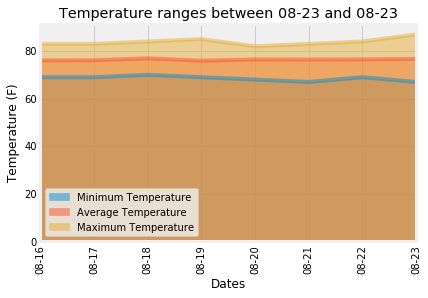

In [32]:
# Plot the daily normals as an area plot with `stacked=False``
daily_normals_df.plot(kind='area', stacked=False)
plt.xticks(rotation=90)
plt.title("Temperature ranges between 08-23 and 08-23")
plt.xlabel("Dates")
plt.ylabel("Temperature (F)")
plt.show()